In [42]:
%matplotlib inline

import h5py
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import allel
import sys
import time 
import os
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE
import umap
from numba import jit

from ipywidgets import interact
import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file


from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy

In [2]:
def import_data():
    populations_data=pd.read_csv("populations.tsv",
                                    delimiter="\t",encoding="utf-8")
    panel_data=pd.read_csv("panel.tsv",
                            delimiter="\t",encoding="utf-8")
    callset= allel.read_vcf('genomes.vcf', fields= "calldata/GT", log=sys.stdout)

    return populations_data,panel_data,callset


In [3]:
populations_data, panel_data, callset= import_data()

[read_vcf] 65536 rows in 23.38s; chunk in 23.38s (2802 rows/s); 1 :233857117
[read_vcf] 131072 rows in 45.55s; chunk in 22.17s (2955 rows/s); 2 :198362018
[read_vcf] 196608 rows in 68.04s; chunk in 22.49s (2914 rows/s); 3 :166304564
[read_vcf] 262144 rows in 90.90s; chunk in 22.86s (2866 rows/s); 5 :1639103
[read_vcf] 327680 rows in 114.10s; chunk in 23.20s (2825 rows/s); 6 :21908093
[read_vcf] 393216 rows in 137.18s; chunk in 23.08s (2839 rows/s); 7 :50536087
[read_vcf] 458752 rows in 160.13s; chunk in 22.95s (2855 rows/s); 8 :115739018
[read_vcf] 524288 rows in 183.43s; chunk in 23.29s (2813 rows/s); 10 :29361379
[read_vcf] 589824 rows in 207.45s; chunk in 24.02s (2728 rows/s); 11 :97383737
[read_vcf] 655360 rows in 230.66s; chunk in 23.21s (2823 rows/s); 13 :40629385
[read_vcf] 720896 rows in 253.95s; chunk in 23.29s (2813 rows/s); 15 :60551926
[read_vcf] 786432 rows in 277.01s; chunk in 23.06s (2842 rows/s); 18 :7607939
[read_vcf] 851968 rows in 301.21s; chunk in 24.20s (2708 rows/

In [ ]:
allel.vcf_to_hdf5('genomes.vcf', 'genomes_new.h5', fields='*', overwrite=True)

In [4]:
callset_h5 = h5py.File('genomes_new.h5', mode='r')
callset_h5

<HDF5 file "genomes_new.h5" (mode r)>

In [5]:
len(callset['calldata/GT'])
gt_arr = allel.GenotypeArray(callset['calldata/GT'])
gt_arr

<GenotypeArray shape=(905788, 3450, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 ./. 0/0 0/0 0/0 ... 0/0 ./. 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/1 0/0 0/1 0/1
...
0/. 0/. 0/. 0/. 0/. ... 0/. 0/. 0/. 0/. 0/.
1/. 1/. 1/. 1/. 1/. ... 1/. 1/. 1/. 1/. 1/.
0/. 0/. 0/. 0/. 0/. ... 0/. 0/. 0/. 0/. 0/.

In [6]:
g = allel.GenotypeChunkedArray(callset_h5['calldata']['GT'])
g_without_pruning= g
g

<GenotypeChunkedArray shape=(905788, 3450, 2) dtype=int8 chunks=(65536, 64, 2)
   nbytes=5.8G cbytes=868.4M cratio=6.9
   compression=gzip compression_opts=1
   values=h5py._hl.dataset.Dataset>

In [7]:
ac = g.count_alleles()[:]
ac

<AlleleCountsArray shape=(905788, 2) dtype=int32>
6797   73
6205  117
6619  241
...
3381   56
 259 3181
3341  103

In [8]:
print(np.count_nonzero(ac.max_allele() > 1))
print(np.count_nonzero((ac.max_allele() == 1) & ac.is_singleton(1)))

0
61


In [9]:
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = g.compress(flt, axis=0)
gf

<GenotypeChunkedArray shape=(905282, 3450, 2) dtype=int8 chunks=(443, 3450, 2)
   nbytes=5.8G cbytes=2.1G cratio=2.8
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [10]:
gn = gf.to_n_alt()
print(gn.shape)
print(gn)

(905282, 3450)
<ChunkedArrayWrapper shape=(905282, 3450) dtype=int8 chunks=(885, 3450)
   nbytes=2.9G cbytes=1.3G cratio=2.2
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>


In [11]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot.pairwise_ld(m)
    ax.set_title(title)

In [12]:
sample_size=100000
vidx = np.random.choice(gn.shape[0], sample_size, replace=False)
vidx.sort()
gnr = gn.take(vidx, axis=0)
gnr

<ChunkedArrayWrapper shape=(100000, 3450) dtype=int8 chunks=(391, 3450)
   nbytes=329.0M cbytes=152.0M cratio=2.2
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [13]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [14]:
gnu = ld_prune(gnr,size=500, step=200, threshold=.1, n_iter=3)


iteration 1 retaining 54661 removing 45339 variants
iteration 2 retaining 54364 removing 297 variants
iteration 3 retaining 54329 removing 35 variants


def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn
gn_new = ld_prune(gn,500,200,0.1,5)

In [145]:
populations_data

,Population Description,Population Code,Super Population,DNA from Blood,Offspring available from trios,Pilot Samples,Phase1 Samples,Final Phase Samples,Total
0,"Chinese Dai in Xishuangbanna, China",CDX,EAS,no,yes,0.0,0.0,99.0,99.0
1,"Han Chinese in Bejing, China",CHB,EAS,no,no,91.0,97.0,103.0,106.0
2,"Japanese in Tokyo, Japan",JPT,EAS,no,no,94.0,89.0,104.0,105.0
3,"Kinh in Ho Chi Minh City, Vietnam",KHV,EAS,yes,yes,0.0,0.0,101.0,101.0
4,"Southern Han Chinese, China",CHS,EAS,no,yes,0.0,100.0,108.0,112.0
5,Bengali in Bangladesh,BEB,SAS,no,yes,0.0,0.0,86.0,86.0
6,"Gujarati Indian in Houston,TX",GIH,SAS,no,yes,0.0,0.0,106.0,106.0
7,Indian Telugu in the UK,ITU,SAS,yes,yes,0.0,0.0,103.0,103.0
8,"Punjabi in Lahore,Pakistan",PJL,SAS,yes,yes,0.0,0.0,96.0,96.0
9,Sri Lankan Tamil in the UK,STU,SAS,yes,yes,0.0,0.0,103.0,103.0


In [15]:
p=populations_data
p.columns = [c.replace(' ', '_') for c in p.columns]
p

,Population_Description,Population_Code,Super_Population,DNA_from_Blood,Offspring_available_from_trios,Pilot_Samples,Phase1_Samples,Final_Phase_Samples,Total
0,"Chinese Dai in Xishuangbanna, China",CDX,EAS,no,yes,0.0,0.0,99.0,99.0
1,"Han Chinese in Bejing, China",CHB,EAS,no,no,91.0,97.0,103.0,106.0
2,"Japanese in Tokyo, Japan",JPT,EAS,no,no,94.0,89.0,104.0,105.0
3,"Kinh in Ho Chi Minh City, Vietnam",KHV,EAS,yes,yes,0.0,0.0,101.0,101.0
4,"Southern Han Chinese, China",CHS,EAS,no,yes,0.0,100.0,108.0,112.0
5,Bengali in Bangladesh,BEB,SAS,no,yes,0.0,0.0,86.0,86.0
6,"Gujarati Indian in Houston,TX",GIH,SAS,no,yes,0.0,0.0,106.0,106.0
7,Indian Telugu in the UK,ITU,SAS,yes,yes,0.0,0.0,103.0,103.0
8,"Punjabi in Lahore,Pakistan",PJL,SAS,yes,yes,0.0,0.0,96.0,96.0
9,Sri Lankan Tamil in the UK,STU,SAS,yes,yes,0.0,0.0,103.0,103.0


In [16]:
##populations = df_samples.population.unique()

populations=p.Population_Code.unique()
populations
p_n=p.dropna()
p_n.shape

(26, 9)

In [17]:
panel_data.head()
panel_head_n=panel_data.dropna() 
pops=panel_head_n.iloc[:,1]
pops=pops.unique()
pops

array(['GBR', 'FIN', 'CHS', 'PUR', 'CDX', 'CLM', 'IBS', 'PEL', 'PJL',
       'KHV', 'ACB', 'GWD', 'ESN', 'BEB', 'MSL', 'STU', 'ITU', 'CEU',
       'YRI', 'CHB', 'JPT', 'LWK', 'ASW', 'MXL', 'TSI', 'GIH'],
      dtype=object)

In [18]:
coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson')

In [232]:
coords1.shape

(3450, 10)

In [ ]:
with open('listfile.txt', 'w') as filehandle:  
    for dims in coords1:
        filehandle.write('%s\n' % dims)

In [49]:
panel_head_n.shape

(3450, 3)

In [19]:
pop_colours = {
    'GBR': '#C0392B' , 
    'FIN': '#AF7AC5', 
    'CHS': '#E74C3C', 
    'PUR': '#00FFFF', 
    'CDX': '#D2B4DE', 
    'CLM': '#A9CCE3', 
    'IBS': '#1F618D', 
    'PEL': '#1F618D', 
    'PJL': '#5DADE2',
    'KHV': '#21618C', 
    'ACB': '#48C9B0', 
    'GWD': '#A3E4D7', 
    'ESN': '#138D75', 
    'BEB': '#229954', 
    'MSL': '#82E0AA', 
    'STU': '#F9E79F', 
    'ITU': '#D4AC0D', 
    'CEU': '#F39C12',
    'YRI': '#D35400', 
    'CHB': '#EDBB99', 
    'JPT': '#909497', 
    'LWK': '#2E4053', 
    'ASW': '#EBDEF0', 
    'MXL': '#F5B7B1', 
    'TSI': '#E9967A', 
    'GIH': '#F08080'
}

In [20]:
coords1.shape
len(pop_colours)


26

In [21]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for p in pops:
        flt = (sample_population == p)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[p], 
                label=p, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = panel_head_n.iloc[:,1]
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

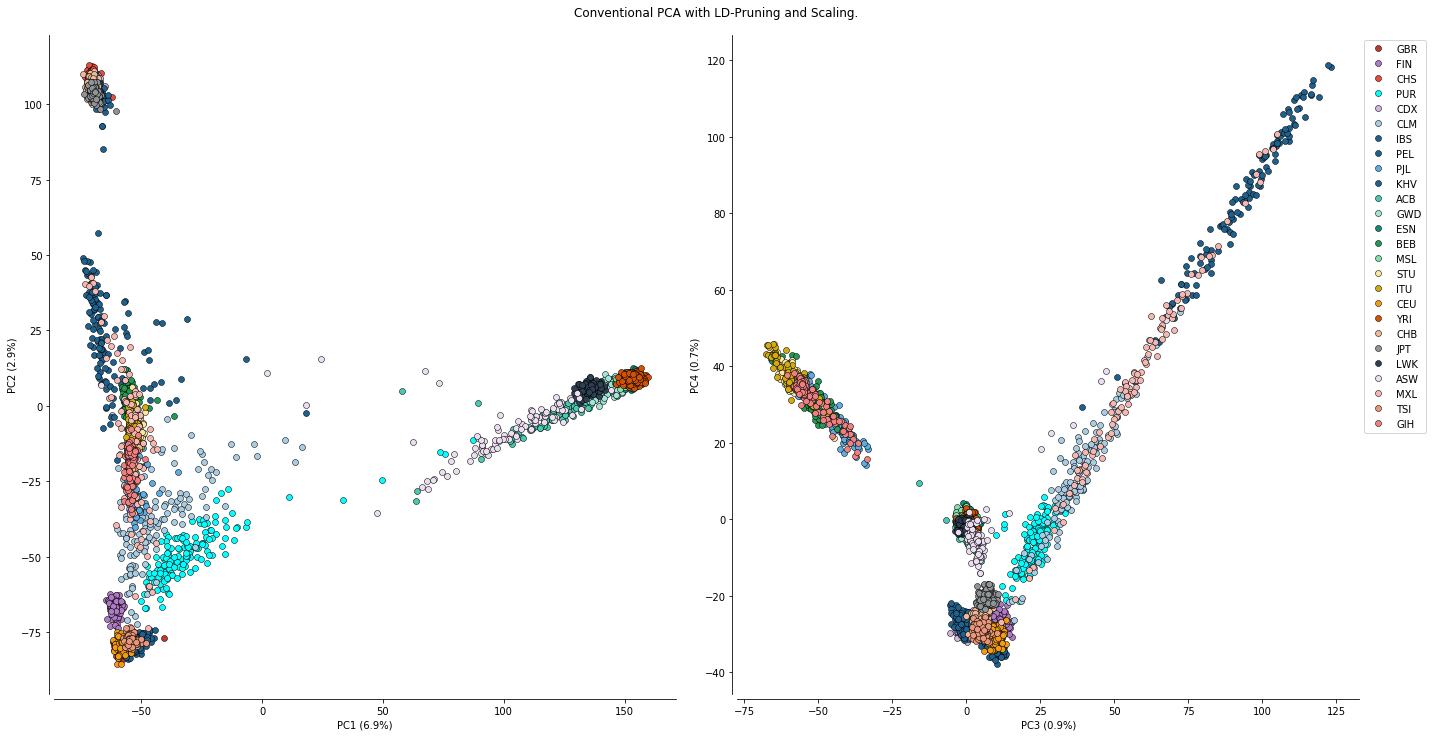

In [22]:
fig_pca(coords1, model1, 'Conventional PCA with LD-Pruning and Scaling.')

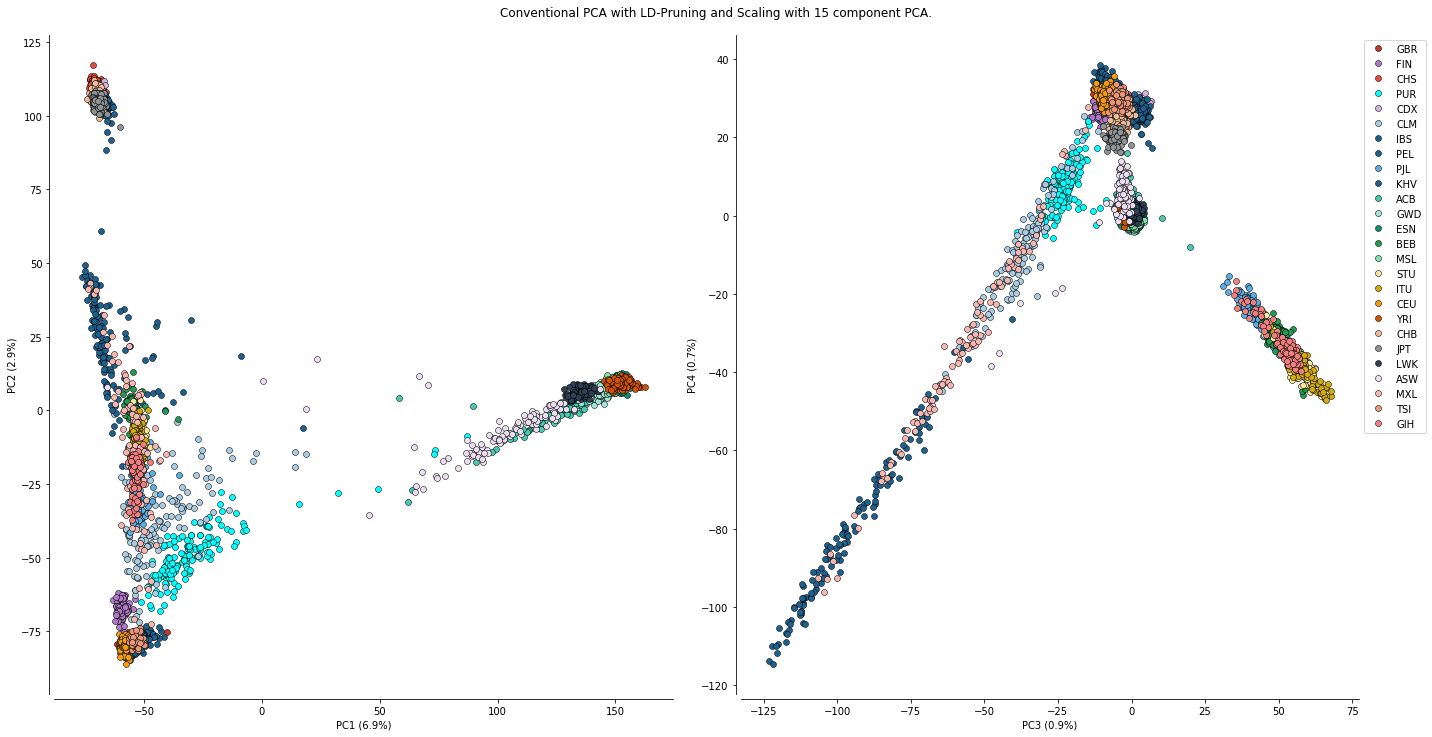

In [167]:
fig_pca(coords1, model1, 'Conventional PCA with LD-Pruning and Scaling with 15 component PCA.')

In [23]:
panel_head_n.groupby('pop').pop.count()

pop
ACB    122
ASW    107
BEB    143
CDX    105
CEU    183
CHB    105
CHS    171
CLM    146
ESN    172
FIN    104
GBR    105
GIH    111
GWD    180
IBS    162
ITU    118
JPT    105
KHV    121
LWK    110
MSL    122
MXL    104
PEL    129
PJL    155
PUR    149
STU    128
TSI    111
YRI    182
Name: pop, dtype: int64

In [24]:
panel_head_n.sample


<bound method NDFrame.sample of        sample  pop  in_phase_3
0     HG00096  GBR         1.0
1     HG00097  GBR         1.0
2     HG00098  GBR         0.0
3     HG00099  GBR         1.0
4     HG00100  GBR         1.0
5     HG00101  GBR         1.0
6     HG00102  GBR         1.0
7     HG00104  GBR         0.0
8     HG00105  GBR         1.0
9     HG00106  GBR         1.0
10    HG00107  GBR         1.0
11    HG00108  GBR         1.0
12    HG00109  GBR         1.0
13    HG00110  GBR         1.0
14    HG00111  GBR         1.0
15    HG00112  GBR         1.0
16    HG00113  GBR         1.0
17    HG00114  GBR         1.0
18    HG00115  GBR         1.0
19    HG00116  GBR         1.0
20    HG00117  GBR         1.0
21    HG00118  GBR         1.0
22    HG00119  GBR         1.0
23    HG00120  GBR         1.0
24    HG00121  GBR         1.0
25    HG00122  GBR         1.0
26    HG00123  GBR         1.0
27    HG00124  GBR         0.0
28    HG00125  GBR         1.0
29    HG00126  GBR         1.0
...    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


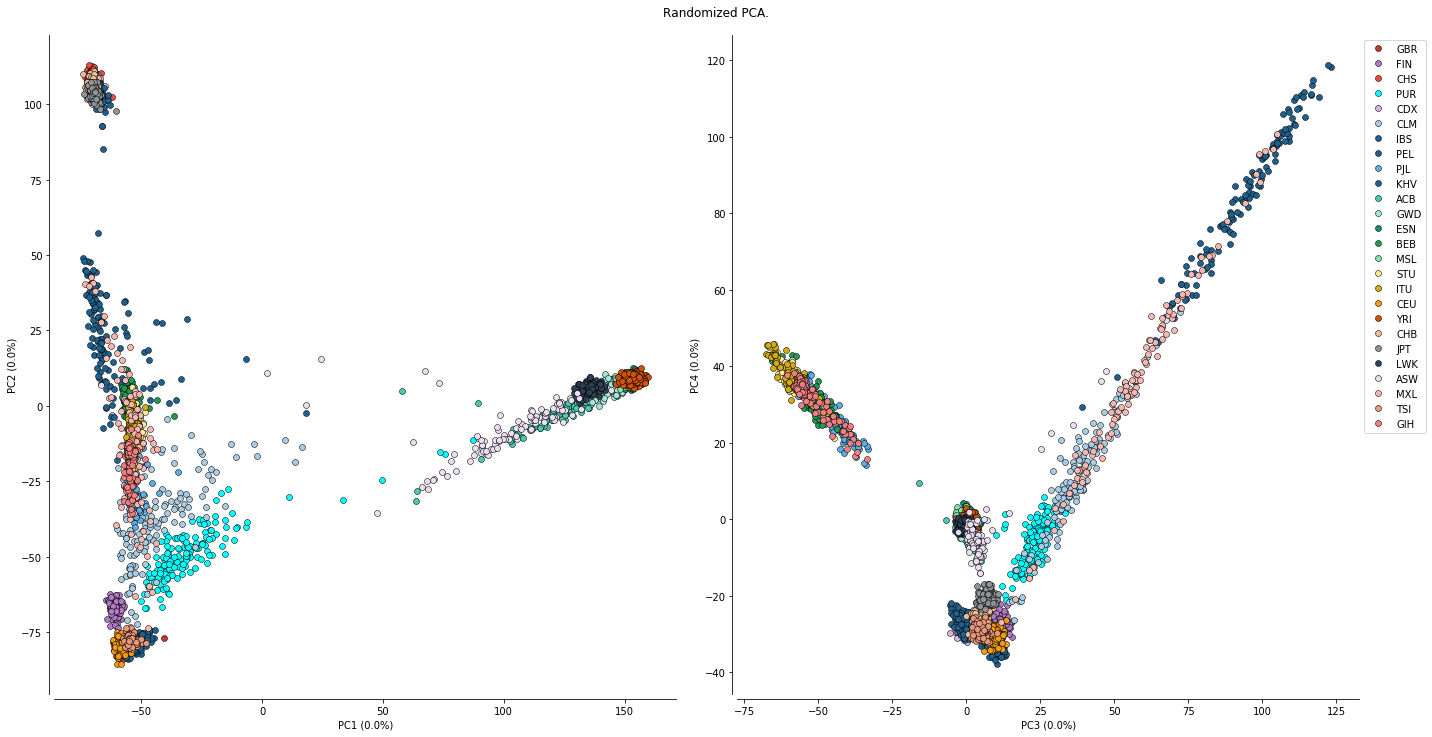

In [25]:
coords2, model2 = allel.randomized_pca(gnu, n_components=10, scaler='patterson')
fig_pca(coords2, model2, 'Randomized PCA.')

In [28]:

fit = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')
%time u = fit.fit_transform(coords3)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


CPU times: user 7.02 s, sys: 562 ms, total: 7.59 s
Wall time: 7.16 s


In [295]:
! pip show numba

Name: numba
Version: 0.42.0
Summary: compiling Python code using LLVM
Home-page: http://numba.github.com
Author: Anaconda, Inc.
Author-email: numba-users@continuum.io
License: BSD
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: llvmlite, numpy
Required-by: umap-learn


In [57]:
type(panel_head_n.iloc[:,1])


pandas.core.series.Series

In [210]:
pops

array(['GBR', 'FIN', 'CHS', 'PUR', 'CDX', 'CLM', 'IBS', 'PEL', 'PJL',
       'KHV', 'ACB', 'GWD', 'ESN', 'BEB', 'MSL', 'STU', 'ITU', 'CEU',
       'YRI', 'CHB', 'JPT', 'LWK', 'ASW', 'MXL', 'TSI', 'GIH'],
      dtype=object)

In [32]:
pop_nos = {
    'GBR': 1, 
    'FIN': 2, 
    'CHS': 3, 
    'PUR': 4, 
    'CDX': 5, 
    'CLM': 6, 
    'IBS': 7, 
    'PEL': 8, 
    'PJL': 9,
    'KHV': 10, 
    'ACB': 11, 
    'GWD': 12, 
    'ESN': 13, 
    'BEB': 14, 
    'MSL': 15, 
    'STU': 16, 
    'ITU': 17, 
    'CEU': 18,
    'YRI': 19, 
    'CHB': 20, 
    'JPT': 21, 
    'LWK': 22, 
    'ASW': 23, 
    'MXL': 24, 
    'TSI': 25, 
    'GIH': 26
}

In [89]:
s=panel_head_n.iloc[:,1].map(pop_nos)
s=list(s)
colors_scatterplot=list(pop_colours.values())
len(s)

3450

In [102]:
u_new=pd.DataFrame(u, columns=list('xy'))
u_new['region']=panel_head_n.iloc[:,1]
u_new

,x,y,region
0,9.265842,-12.484778,GBR
1,8.859578,-12.910412,GBR
2,8.699066,-12.549387,GBR
3,8.439351,-12.418157,GBR
4,8.530403,-12.825469,GBR
5,9.231421,-13.087831,GBR
6,8.308864,-12.627419,GBR
7,8.601204,-12.512207,GBR
8,8.640862,-12.537000,GBR
9,8.712397,-12.886286,GBR


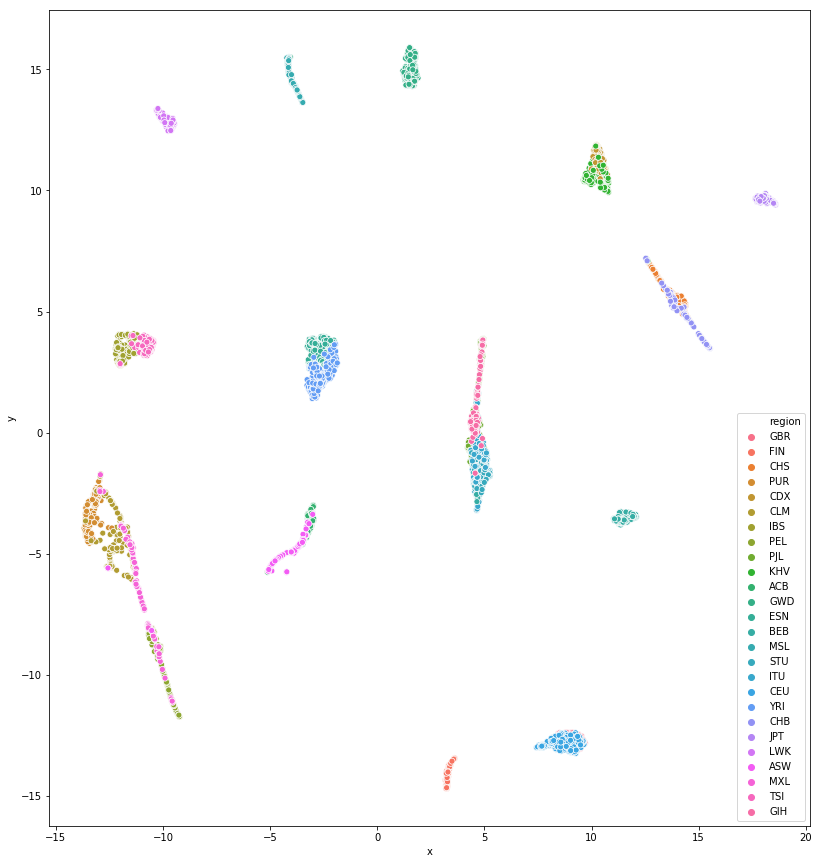

In [106]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(1, 2, 1)
ax = sns.scatterplot(x="x", y="y", hue="region",data=u_new)